# Geospatial analysis of uber tlc foil data
Using this dataset, please predict the demand of Uber pickups by location for October 2014. Attach a document with your prediction results.

Please state all the assumptions that you make, show as much of your work as possible, and explain any algorithm you use and why you used it.

In [54]:
%matplotlib inline

import numpy as np
import pandas as pd #high-performance, easy-to-use data structures and data analysis tools
import geopandas #extends the datatypes used by pandas to allow spatial operations on geometric types
import mapclassify as mc #Classification schemes for choropleth mapping

from multiprocessing import cpu_count
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from shapely.geometry import Point, Polygon
from datetime import timedelta
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import filterwarnings, catch_warnings

pd.options.display.max_rows = 200
warnings.filterwarnings('ignore')

#from scipy import ndimage

## Importing & formatting uber tlc foil ride data

**Rides**  
Contains a list of all rides between April and September of 2014 in a GeoPandas GeoDataFrame. "geometry" describes the ride's pickup location as a geodata CRS point

In [2]:
#create GeoDataFrame 'rides' from the uber TLC FOIL CSVs
rides = pd.read_csv("./data/uber-raw-data-apr14.csv").pipe(geopandas.GeoDataFrame) #for testing purposes

In [3]:
rides = pd.concat(
    [
        pd.read_csv("./data/uber-raw-data-apr14.csv"),
        pd.read_csv("./data/uber-raw-data-may14.csv"),
        pd.read_csv("./data/uber-raw-data-jun14.csv"),
        pd.read_csv("./data/uber-raw-data-jul14.csv"),
        pd.read_csv("./data/uber-raw-data-aug14.csv"),
        pd.read_csv("./data/uber-raw-data-sep14.csv"),
    ]
).pipe(geopandas.GeoDataFrame)

In [3]:
#~60 seconds
#Format 'rides' as a GeoDataFrame array
rides['Date/Time'] = pd.to_datetime(rides['Date/Time'])
rides['date'] = pd.to_datetime(rides['Date/Time'].dt.strftime("%Y-%m-%d %H:00:00"))
#rides['Date/Time'].dt.date
rides['geometry'] = list(zip(rides.Lon.astype(float), rides.Lat.astype(float)))
rides['geometry'] = rides['geometry'].apply(Point)
rides.head()

,Date/Time,Lat,Lon,Base,date,geometry
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,POINT (-73.95489999999999 40.769)
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,POINT (-74.03449999999999 40.7267)
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,POINT (-73.9873 40.7316)
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,POINT (-73.9776 40.7588)
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,POINT (-73.9722 40.7594)


In [4]:
rides

,Date/Time,Lat,Lon,Base,date,geometry
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01 00:00:00,POINT (-73.95489999999999 40.769)
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01 00:00:00,POINT (-74.03449999999999 40.7267)
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01 00:00:00,POINT (-73.9873 40.7316)
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01 00:00:00,POINT (-73.9776 40.7588)
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01 00:00:00,POINT (-73.9722 40.7594)
5,2014-04-01 00:33:00,40.7383,-74.0403,B02512,2014-04-01 00:00:00,POINT (-74.0403 40.7383)
6,2014-04-01 00:39:00,40.7223,-73.9887,B02512,2014-04-01 00:00:00,POINT (-73.98869999999999 40.7223)
7,2014-04-01 00:45:00,40.7620,-73.9790,B02512,2014-04-01 00:00:00,POINT (-73.979 40.762)
8,2014-04-01 00:55:00,40.7524,-73.9960,B02512,2014-04-01 00:00:00,POINT (-73.99600000000001 40.7524)
9,2014-04-01 01:01:00,40.7575,-73.9846,B02512,2014-04-01 01:00:00,POINT (-73.9846 40.7575)


**Neighborhoods**  
A GeoDataFrame that describe the physical boundries of distinct neighborhoods within New York City. This will be used for grouping of ride pickup coordinates into discrete locations.

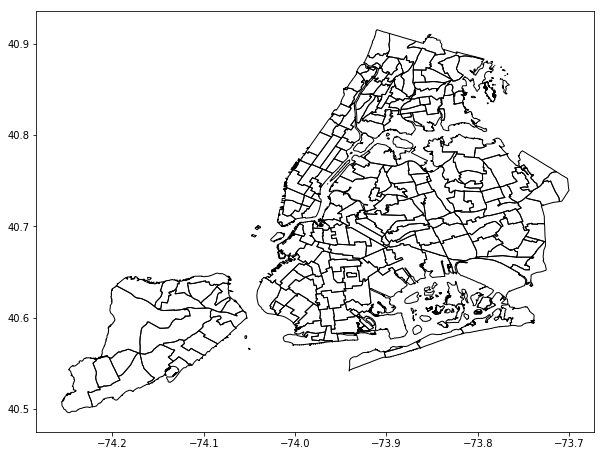

In [5]:
neighborhoods = geopandas.read_file("./data/Neighborhood_Tabulation_Areas.geojson")
neighborhoods.crs = rides.crs
neighborhoods.plot(edgecolor='k', facecolor='none', figsize=(10, 10))

## Data Analysis  
**Associating pickup coordinates with neighborhoods**  
By using geopandas sjoin function, we are able to match the pickup location of each ride with the neighborhood in which it took place. This information is used to group the series of ride pickup CRS coordinates into distinct "locations" (i.e., neighborhoods).

In [6]:
#spatially join rides data to neighborhoods data based on CRS coordinates
ridesJoinNeighborhood = geopandas.sjoin(rides, neighborhoods, op='within', how='left')
ridesJoinNeighborhood.head()

,Date/Time,Lat,Lon,Base,date,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,POINT (-73.95489999999999 40.769),43.0,MN31,21501377.3638,061,Lenox Hill-Roosevelt Island,37708.3342924,Manhattan,1
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,POINT (-74.03449999999999 40.7267),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,POINT (-73.9873 40.7316),156.0,MN22,10894316.0859,061,East Village,13555.2394504,Manhattan,1
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,POINT (-73.9776 40.7588),100.0,MN17,30191534.1874,061,Midtown-Midtown South,27032.7004332,Manhattan,1
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,POINT (-73.9722 40.7594),13.0,MN19,17393274.6306,061,Turtle Bay-East Midtown,21412.5981855,Manhattan,1


**Aggregating Data**  
*ridesPerNeighborhood* counts the number of rides per grouping of date & neighborhood in *ridesJoinNeighborhood*

In [9]:
#Ride count per [neighborhood, date] DataFrame
ridesPerNeighborhood = ridesJoinNeighborhood.rename(index=str, columns={"Date/Time": "count"}).groupby(['date','ntaname'], as_index=False)[['count']].count()
ridesPerNeighborhood

,date,ntaname,count
0,2014-04-01 00:00:00,Airport,6
1,2014-04-01 00:00:00,Battery Park City-Lower Manhattan,8
2,2014-04-01 00:00:00,Bedford,1
3,2014-04-01 00:00:00,Central Harlem North-Polo Grounds,1
4,2014-04-01 00:00:00,Chinatown,6
5,2014-04-01 00:00:00,Clinton,4
6,2014-04-01 00:00:00,Clinton Hill,1
7,2014-04-01 00:00:00,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,1
8,2014-04-01 00:00:00,East Harlem North,3
9,2014-04-01 00:00:00,East New York,1


**Todo: analyze data for all neighborhoods (for loop), and let the user select which neighborhood they want to review**  

**Choosing a neighborhood to forecast**  
Define the variable 'neighborhood' to generate a custom model for forecasting the number of pickups per day over the month of Oct, 2014. To see a list of NYC neighborhoods, execute the following line.

In [10]:
neighborhood = 'East Village'
ridesInSelectedNeighborhood = ridesPerNeighborhood[ridesPerNeighborhood['ntaname'] == neighborhood]
ridesInSelectedNeighborhood = ridesInSelectedNeighborhood.drop(columns='ntaname')
ridesInSelectedNeighborhood = ridesInSelectedNeighborhood.reset_index(drop=True)

In [11]:
print(neighborhoods['ntaname'])

0                                           Borough Park
1                                            Murray Hill
2                                          East Elmhurst
3                                                 Hollis
4                                         Manhattanville
5                              Springfield Gardens North
6                                              Homecrest
7                                                 Corona
8      Mariner's Harbor-Arlington-Port Ivory-Granitev...
9                                  Westchester-Unionport
10                                  Fresh Meadows-Utopia
11                                               Erasmus
12                                              Longwood
13                               Turtle Bay-East Midtown
14                                            St. Albans
15                            Jamaica Estates-Holliswood
16                                               Madison
17                             

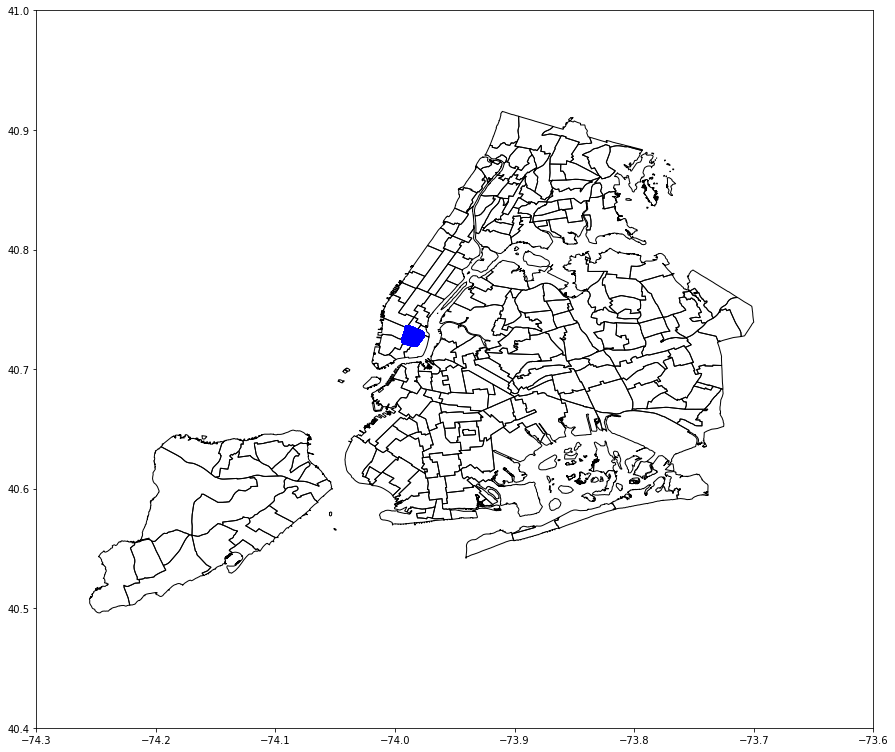

In [12]:
#visualize the selected neighborhood:
ax = neighborhoods.plot(edgecolor='k', facecolor='none', figsize=(15, 15))
ax.set(xlim=(-74.3, -73.6), ylim=(40.4, 41))
ridesJoinNeighborhood[ridesJoinNeighborhood['ntaname'] == neighborhood].plot(ax=ax, color='blue')

In [13]:
#https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
def plotRides(x, y):
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
    plt.axis([np.min(x), np.max(x), np.min(y), np.max(y)])
    plt.xlabel('Date')
    plt.ylabel('Number of Rides')
    plt.title('Uber Rides in ' + neighborhood + ' Neighborhood')
    plt.show()

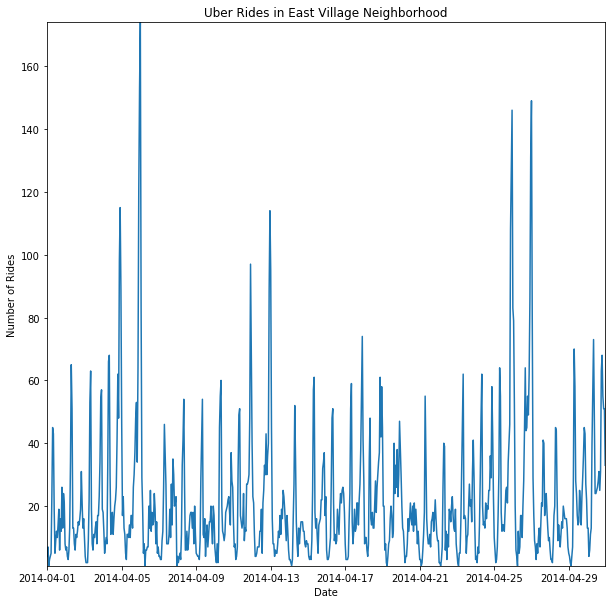

In [14]:
plotRides(
    ridesInSelectedNeighborhood['date'], 
    ridesInSelectedNeighborhood['count']
)

## SARIMA forecasting
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/  
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/  
http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

# Define SARIMA hyperparamaters:  
It is an effective approach for time series forecasting, although it requires careful analysis and domain expertise in order to configure the seven or more model hyperparameters.  
It adds three new hyperparameters to specify:
* the autoregression (AR)  
* differencing (I)  
* and moving average (MA) for the seasonal component of the series  
* an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

They are the same as the ARIMA model; specifically:
* p: Trend autoregression order.
* d: Trend difference order.
* q: Trend moving average order.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:
* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.

In [15]:
data = ridesInSelectedNeighborhood['count']
# define model trend configuration (pdq)
my_order = (1, 1, 1)
# define model seasonal configuration (PDQm)
my_seasonal_order = (1, 1, 1, 12)
# define model
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()

In [16]:
yhat = round(model_fit.predict(start=len(data), end=len(data)+744)).astype(int)
yhat

717     30
718     26
719     21
720     17
721     18
722     20
723     23
724     32
725     42
726     36
727     29
728     29
729     29
730     26
731     22
732     19
733     20
734     22
735     30
736     38
737     44
738     39
739     33
740     30
741     30
742     26
743     22
744     19
745     20
746     22
747     29
748     37
749     44
750     39
751     33
752     30
753     30
754     27
755     23
756     20
757     20
758     22
759     30
760     38
761     45
762     39
763     33
764     31
765     31
766     27
767     23
768     20
769     21
770     23
771     30
772     38
773     45
774     39
775     34
776     31
777     31
778     27
779     23
780     21
781     21
782     23
783     30
784     38
785     45
786     40
787     34
788     31
789     31
790     28
791     24
792     21
793     21
794     23
795     31
796     39
797     46
798     40
799     34
800     32
801     32
802     28
803     24
804     21
805     22
806     24
807     31

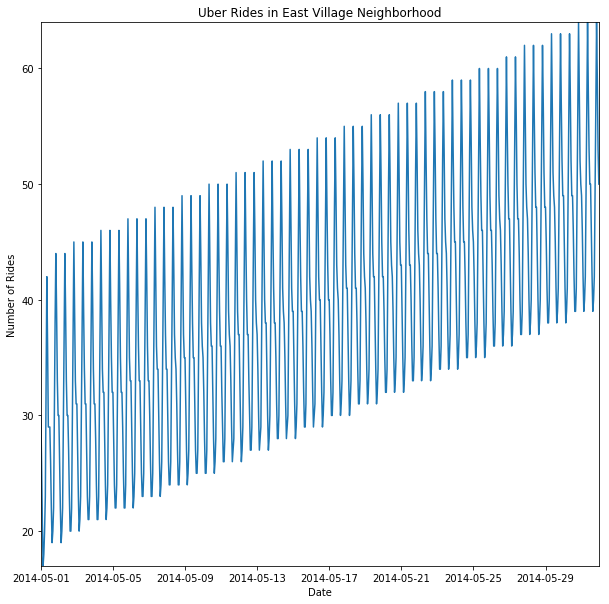

In [17]:
#Build october rides DataFrame
d = []
for i in range(len(yhat)-1):
    d.append({'date': max(ridesInSelectedNeighborhood['date'])+ timedelta(hours=i+1),
            'count': yhat.iloc[i]})

octRidesInSelectedNeighborhood = pd.DataFrame(d)
plotRides(
    octRidesInSelectedNeighborhood['date'], 
    octRidesInSelectedNeighborhood['count']
)

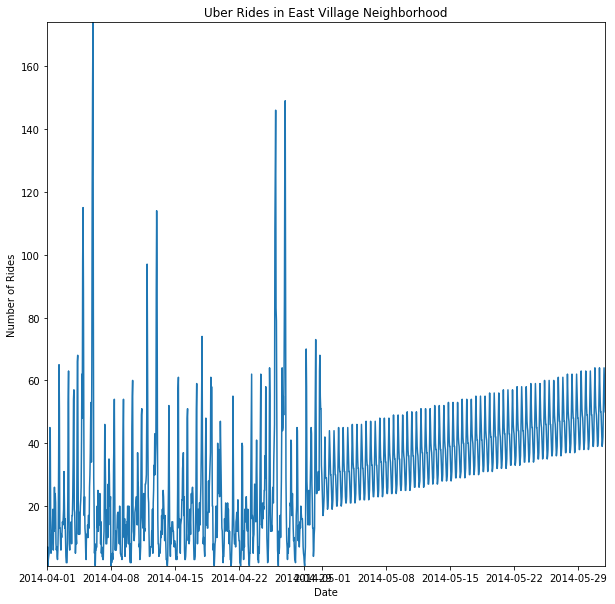

In [18]:
test = ridesInSelectedNeighborhood.append(octRidesInSelectedNeighborhood)
plotRides(
    test['date'], 
    test['count']
)

In [ ]:
# todo: 
# adjust seasonal variables for better match

In [19]:
# function that will fit a model with a given configuration and make a one-step forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [20]:
# train_test_split() function below implements this for a provided dataset and a specified number of time steps to use in the test set
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [21]:
# The measure_rmse() function below will calculate the RMSE given a list of actual (the test set) and predicted values
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

**walk_forward_validation()**  
First, a provided univariate time series dataset is split into train and test sets using the train_test_split() function. Then the number of observations in the test set are enumerated. For each we fit a model on all of the history and make a one step forecast. The true observation for the time step is then added to the history and the process is repeated. The sarima_forecast() function is called in order to fit a model and make a prediction. Finally, an error score is calculated by comparing all one-step forecasts to the actual test set by calling the measure_rmse() function.

We can call walk_forward_validation() repeatedly with different lists of model configurations.

In [22]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

**score_model()**  
We can trap exceptions and ignore warnings during the grid search by wrapping all calls to walk_forward_validation() with a try-except and a block to ignore warnings. We can also add debugging support to disable these protections in the case we want to see what is really going on. Finally, if an error does occur, we can return a None result, otherwise we can print some information about the skill of each model evaluated. This is helpful when a large number of models are evaluated.

In [23]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

**sarima_configs()**  
The sarima_configs() function below will create a list of model configurations to evaluate.

The configurations assume each of the AR, MA, and I components for trend and seasonality are low order, e.g. off (0) or in [1,2]. You may want to extend these ranges if you believe the order may be higher. An optional list of seasonal periods can be specified, and you could even change the function to specify other elements that you may know about your time series.

In theory, there are 1,296 possible model configurations to evaluate, but in practice, many will not be valid and will result in an error that we will trap and ignore.

In [30]:
# create a set of all sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

**grid_search()**  
The grid_search() function below implements this behavior given a univariate time series dataset, a list of model configurations (list of lists), and the number of time steps to use in the test set. An optional parallel argument allows the evaluation of models across all cores to be tuned on or off, and is on by default.

In [50]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [56]:
cfg_list = sarima_configs()
scores = grid_search(data, cfg_list, 4, True)

In [59]:
scores

[]

In [60]:
# review environment.yml and remove dependencies not used